In [ ]:
!pip install qutip

In [ ]:
!pip install krotov

In [ ]:
import sys
import os
import qutip
import numpy as np
import scipy
import matplotlib
import matplotlib.pylab as plt
import krotov
from scipy.fftpack import fft
from scipy.interpolate import interp1d


from scipy.stats import unitary_group

In [ ]:
def guess_control1(t, args , ampl0=0.2):
    return ampl0 * krotov.shapes.flattop(
        t, t_start=0, t_stop=5, t_rise=0.3, func="blackman"
    )
def guess_control2(t , args,ampl0=0.2):
    return ampl0 * krotov.shapes.flattop(
        t, t_start=0, t_stop=5, t_rise=0.3, func="blackman"
    )

In [ ]:
def hamiltonian(omega=1 , ampl0=0.2 ):
    H0 = -0.5 * omega * qutip.operators.sigmaz()
    H1 = qutip.operators.sigmax()
    H2 = qutip.operators.sigmay()

    return [H0,[H1,guess_control1],[H2,guess_control2]]


In [ ]:
H = hamiltonian()
H

[Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[-0.5  0. ]
  [ 0.   0.5]],
 [Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
  Qobj data =
  [[0. 1.]
   [1. 0.]],
  <function __main__.guess_control1(t, args, ampl0=0.2)>],
 [Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
  Qobj data =
  [[0.+0.j 0.-1.j]
   [0.+1.j 0.+0.j]],
  <function __main__.guess_control2(t, args, ampl0=0.2)>]]

In [ ]:
tlist = np.linspace(0, 5, 500)

In [ ]:
def logical_basis(H):
    H0 = H[0]
    eigenvals, eigenvecs = scipy.linalg.eig(H0.full())
    ndx = np.argsort(eigenvals.real)
    E = eigenvals[ndx].real
    V = eigenvecs[:, ndx]
    psi0 = qutip.Qobj(V[:, 0])
    psi1 = qutip.Qobj(V[:, 1])
    w01 = E[1] - E[0]  # Transition energy between states
    print("Energy of qubit transition is %.3f" % w01)
    return psi0, psi1

psi0, psi1 = logical_basis(H)

Energy of qubit transition is 1.000


In [ ]:
proj0 = qutip.ket2dm(psi0)
proj1 = qutip.ket2dm(psi1)

In [ ]:
RandU=[0]*100
for i in range(100):
    RandU[i] = unitary_group.rvs(2)
print(RandU)

[array([[-0.39002681+0.20327751j, -0.59784268-0.67018018j],
       [ 0.85843068-0.26392065j, -0.22847425-0.375822j  ]]), array([[-0.7715815 -0.08466927j, -0.54079634+0.32408707j],
       [-0.62701863+0.06588434j,  0.56589103-0.53129487j]]), array([[ 0.22410805-0.9481497j , -0.14188857-0.17508671j],
       [ 0.18484158+0.12892368j, -0.92956829+0.29174486j]]), array([[ 0.35114276+0.26509303j,  0.88897989-0.12704019j],
       [-0.89020149+0.1181768j ,  0.26633981-0.35019802j]]), array([[ 0.46584725-0.10507576j,  0.38131953+0.79154332j],
       [ 0.75984056-0.441121j  , -0.32659156-0.34841432j]]), array([[-0.06416799+0.32818955j, -0.05223863+0.94098099j],
       [ 0.78905457+0.51533191j, -0.30242058-0.14271546j]]), array([[ 0.16380703-0.58976389j,  0.74801315+0.25655825j],
       [-0.47719107-0.63058266j, -0.50918424+0.33968456j]]), array([[-0.39457497+0.08964254j, -0.25151179+0.87921364j],
       [-0.26576388+0.87501107j, -0.2828093 -0.28938571j]]), array([[-0.69677261+0.57187662j,  0.004

In [ ]:
objectives=[0]*100
for i in range(100):
  objectives[i] = krotov.gate_objectives(
      basis_states=[psi0, psi1], gate=RandU[i], H=H
  )



def S(t):
    """Scales the Krotov methods update of the pulse value at the time t"""
    return krotov.shapes.flattop(
        t, t_start=0, t_stop=5, t_rise=0.3, t_fall=0.3, func='blackman'
   )
pulse_options = {
    H[1][1]: dict(lambda_a=1, update_shape=S),
    H[2][1]: dict(lambda_a=1, update_shape=S)
}

In [ ]:
results=[]
for i in range(100):

  opt_result = krotov.optimize_pulses(
      objectives[i],
      pulse_options=pulse_options,
      tlist=tlist,
      propagator=krotov.propagators.expm,
      chi_constructor=krotov.functionals.chis_sm,
      info_hook=krotov.info_hooks.print_table(J_T=krotov.functionals.J_T_sm),
      check_convergence=krotov.convergence.Or(
          krotov.convergence.value_below('1e-3', name='J_T'),
          krotov.convergence.check_monotonic_error,
      ),
      store_all_pulses=True,
  )

  results.append(opt_result)


  #j_f=[]
  #j_f.append(opt_result.info_vals)
#print(j_f)


iter.      J_T   ∑∫gₐ(t)dt          J       ΔJ_T         ΔJ  secs
0     6.76e-01    0.00e+00   6.76e-01        n/a        n/a     3
1     1.28e-01    2.00e-01   3.29e-01  -5.48e-01  -3.47e-01     8
2     5.98e-03    5.58e-02   6.18e-02  -1.22e-01  -6.66e-02     8
3     9.73e-05    2.78e-03   2.88e-03  -5.88e-03  -3.10e-03     7
iter.      J_T   ∑∫gₐ(t)dt          J       ΔJ_T         ΔJ  secs
0     8.75e-01    0.00e+00   8.75e-01        n/a        n/a     4
1     1.14e-01    2.05e-01   3.19e-01  -7.61e-01  -5.56e-01     7
2     5.41e-03    5.05e-02   5.59e-02  -1.08e-01  -5.76e-02     8
3     1.06e-03    2.02e-03   3.08e-03  -4.35e-03  -2.32e-03     8
4     1.98e-04    3.99e-04   5.97e-04  -8.60e-04  -4.60e-04     7
iter.      J_T   ∑∫gₐ(t)dt          J       ΔJ_T         ΔJ  secs
0     9.11e-01    0.00e+00   9.11e-01        n/a        n/a     4
1     3.57e-01    1.50e-01   5.07e-01  -5.54e-01  -4.04e-01     7
2     2.19e-03    1.57e-01   1.59e-01  -3.55e-01  -1.98e-01     8
3     4.04

In [ ]:
J_F_const_2K=[]
for i in range(100):
  J_F_const_2K.append(results[i].info_vals)

J_F_const_2K

[[0.676128691696805,
  0.1284126921801364,
  0.005978701998346492,
  9.730227146553805e-05],
 [0.8747950110307539,
  0.11350106514808544,
  0.005405712716092581,
  0.0010572715871266514,
  0.00019760457092965478],
 [0.9109521728913373,
  0.357167459539403,
  0.0021879930899856292,
  4.044304077299721e-06],
 [0.8682768404622672, 0.09502573496278255, 0.00045624960452828045],
 [0.9855408413562994,
  0.7660151534852122,
  0.08445188992350083,
  0.001905270536696646,
  6.268858196056826e-05],
 [0.9592350033559409,
  0.4086636321424081,
  0.007068634028379761,
  0.0006422071460119305],
 [0.9997839020598598,
  0.9973343459700722,
  0.9675327694396331,
  0.6835433628051835,
  0.08453182519675728,
  0.001403074634158119,
  7.099080157502158e-06],
 [0.9445297556219193,
  0.3751600475576896,
  0.04291670710594009,
  0.005712679246362651,
  0.0006359909011962595],
 [0.985157618530411,
  0.9412525816717584,
  0.8450712910273523,
  0.6529181592290205,
  0.25351987285711763,
  0.01752137677662713,
  

In [ ]:
iter_sec_const_2K=[]
for i in range(100):
  iter_sec_const_2K.append(results[i].iter_seconds)

iter_sec_const_2K

[[3, 8, 8, 7],
 [4, 7, 8, 8, 7],
 [4, 7, 8, 8],
 [3, 7, 7],
 [4, 8, 8, 7, 8],
 [3, 8, 8, 7],
 [4, 7, 8, 7, 7, 8, 8],
 [3, 8, 7, 8, 8],
 [3, 8, 7, 8, 8, 7, 8],
 [3, 8, 8, 7],
 [4, 7, 8],
 [3, 8, 7, 7],
 [3, 7, 8, 7, 7],
 [3, 8, 7, 7],
 [4, 7, 8, 7],
 [3, 7, 7, 8, 7],
 [4, 7, 8, 8, 7],
 [4, 7, 7, 8],
 [3, 8, 7],
 [4, 7, 8, 8],
 [3, 7, 7],
 [3, 8, 7, 7, 8, 8],
 [3, 8, 7, 8],
 [3, 8, 8, 7],
 [4, 7, 7, 7],
 [3, 7, 7],
 [3, 8, 8, 7, 8],
 [3, 8, 8, 7, 8, 8, 7, 8, 7],
 [3, 7, 8, 8],
 [3, 8, 7, 8, 8, 7],
 [4, 7, 8, 8, 7],
 [3, 7, 8, 7, 7],
 [3, 8, 8],
 [3, 8, 7, 8, 8],
 [3, 8, 7, 8, 8],
 [3, 8, 7, 8, 8],
 [3, 7, 7, 8, 8, 7],
 [3, 7, 8],
 [3, 8, 7, 8, 7, 7],
 [4, 7, 7, 8, 7, 7, 7, 7, 7, 7, 7, 8],
 [3, 8, 7],
 [4, 7, 8, 7, 7, 8],
 [3, 8, 7, 8],
 [3, 8, 7],
 [3, 7, 7, 8],
 [3, 7, 7, 7, 7, 7, 8, 7, 7, 7, 6, 7],
 [3, 8, 8],
 [3, 7, 7],
 [4, 7, 8, 7, 7],
 [3, 8, 8, 7],
 [4, 7, 8, 8, 7, 8],
 [3, 8, 7, 7],
 [3, 7, 7, 7],
 [4, 7, 7, 8],
 [3, 7],
 [3, 7, 7, 8],
 [3, 8, 7, 7],
 [3, 8, 7],
 [3, 7, 8, 7],
 

In [ ]:
t_conv_const_2K=[]

for i in range(100):
  t_sec = 0
  t_conv_i=[]
  for j in range (len(iter_sec_const_2K[i])):
     t_sec = iter_sec_const_2K[i][j] + t_sec
     t_conv_i.append(t_sec)
  t_conv_const_2K.append(t_conv_i)



In [ ]:
N=100
t_conv_avg_2K=0
sum=0
for i in range(N):

  sum=t_conv_const_2K[i][-1] + sum
t_conv_avg_2K= sum/N


In [ ]:
N=100
J_F_avg_2K=0
sum=0
for i in range(N):

  sum=J_F_const_2K[i][-1] + sum
J_F_avg_2K= sum/N



In [ ]:
N=100
t_it_avg_const_2K=0
t1=0
for i in range(N):
  t1= t_conv_const_2K[i][-1]/len(iter_sec_const_2K[i]) + t1

t_it_avg_const_2K = t1/N



t_it_avg_const_2K

6.453856532356533

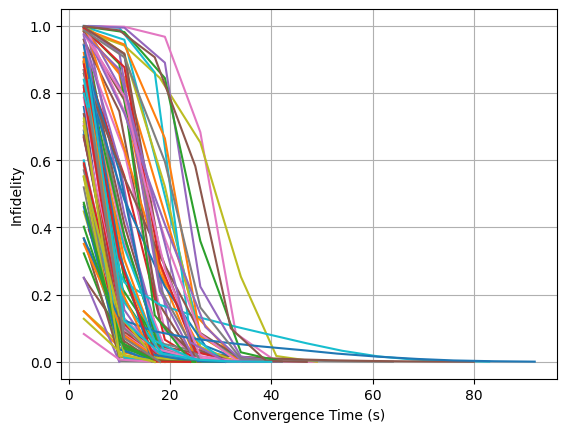

In [ ]:
for i in range(100):
  plt.plot(t_conv_const_2K[i], J_F_const_2K[i])
  #plot_conv(J_F_100_1K[i], t_conv_100_1K[i])
  plt.grid('on')
  plt.xlabel("Convergence Time (s)")
  plt.ylabel("Infidelity")
  #plt.title('Krotov')
  #plt.legend()
  plt.label=('Krotov')
#plt.savefig('ConvPlots5.png')